## Setup

In [ ]:
!pip install cafaeval

import sys
import os
import logging
import yaml
import torch
from google.colab import drive, files

drive.mount('/content/drive')

# Set directories and configuration file
PROJECT_DIR = "/content/drive/MyDrive/pfp"
CONFIG_FILE = f"{PROJECT_DIR}/config.yaml"
SRC_DIR = f"{PROJECT_DIR}/src"
RESULTS_DIR = f"{PROJECT_DIR}/results"
EVALUATIONS_DIR = f"{RESULTS_DIR}/evaluations"

# Add the src directory to the Python path
sys.path.append(SRC_DIR)

# Choose device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device: {device}")

# Load the configuration data from the YAML file
with open(CONFIG_FILE, 'r') as f:
    config_data = yaml.safe_load(f)

Mounted at /content/drive
Device: cuda


### File paths

In [ ]:
# Set file paths
OBO_FILE = config_data['paths']['go_obo']
CUSTOM_TEST_GROUND_TRUTH_FILE = config_data['paths']['custom_test_ground_truth']

### Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cafaeval
from cafaeval.evaluation import cafa_eval, write_results

## Predictions Evaluation

In [ ]:
# Evaluate predictions
alpha_levels = np.arange(0.0, 1.1, 0.1).round(1).tolist()
cafaeval_results = {}
for alpha in alpha_levels:
    PREDICTIONS_DIR = f"{EVALUATIONS_DIR}/test-alpha-{alpha}/predictions"
    cafaeval_results[str(alpha)] = cafa_eval(OBO_FILE, PREDICTIONS_DIR, CUSTOM_TEST_GROUND_TRUTH_FILE)

In [ ]:
# Write all results to .tsv
for alpha in alpha_levels:
    OUT_DIR = f"{EVALUATIONS_DIR}/test-alpha-{alpha}/eval"
    write_results(*cafaeval_results[str(alpha)], OUT_DIR)

In [ ]:
# Load full results DataFrame and add "alpha" column
results_df = pd.DataFrame()
for alpha in alpha_levels:
    IN_DIR = f"{EVALUATIONS_DIR}/test-alpha-{alpha}/eval/evaluation_best_f.tsv"
    df = pd.read_csv(IN_DIR, sep='\t')
    results_df = pd.concat([results_df, df])
results_df['alpha'] = results_df['filename'].str.replace(r'submission_|\.tsv', '', regex=True)

## Plot F-scores by Alpha Level

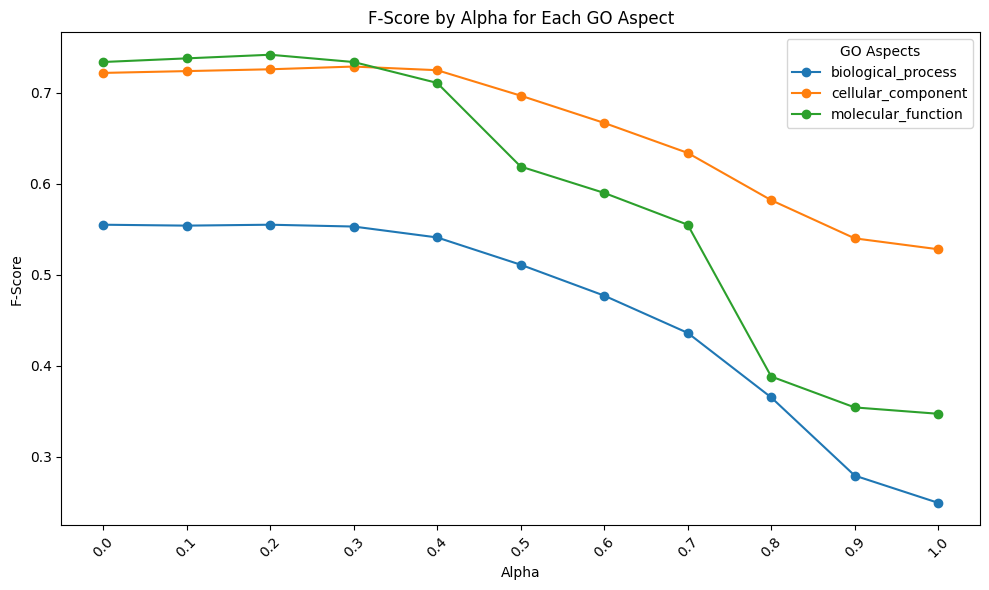

In [ ]:
# Group by GO aspect and plot best F-scores by alpha level
groups = results_df.groupby('ns')

plt.figure(figsize=(10, 6))
for name, group in groups:
    if 'alpha' in group:
        plt.plot(group['alpha'], group['f'], marker='o', label=name)
    else:
        print(f"'alpha' not found in group: {name}")

plt.xlabel('Alpha')
plt.ylabel('F-Score')
plt.title('F-Score by Alpha for Each GO Aspect')
plt.xticks(rotation=45)
plt.legend(title='GO Aspects')
plt.tight_layout()
plt.show()